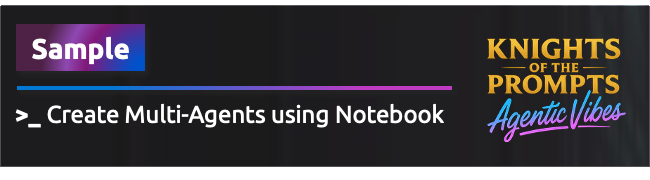

# Sample: Create Multi-Agent System using Jupyter Notebooks

In this lab, we build a modern, production-ready multi-agent system using the latest Azure AI Python SDKs and best practices (as of mid-2025).
- Each agent is created as a connected agent using Azure AI Agent Service.
- Orchestration is performed using direct agent-to-agent calls, not just a group chat or plugin pattern.
- Uses official Microsoft documentation patterns for agent creation, tool/resource registration, and message passing.

The multi-agent system we create will consist of 3 agents that work together to generate detailed reports about health insurance policy documents, brought together using orchestration logic:

1. Search Agent - This agent will search our Azure AI Search index for information about specific health plan policies.
2. Report Agent - This agent will generate a detailed report about the health plan policy based on the information returned from the Search Agent.
3. Validation Agent - This agent will validate that the generated report meets specified requirements. In our case, making sure that the report contains information about coverage exclusions.
4. Orchestrator logic - we use direct orchestration logic written in Python to coordinate the three agents (Search, Report, Validation) using the Azure AI Agent Service SDK.

Orchestration is a key part of multi-agentic systems since the agents that we create need to be able to communicate with each other in order to accomplish the objective. 

We'll use the Azure AI Agent Service not only to create the Search, Report, and Validation agents, but also to build our orchestration logic! At Microsoft Build 2025, Microsoft announced that the Azure AI Agent Service SDK now supports multi-agent capabilities natively. This means you can create, connect, and orchestrate multiple agents directly using the SDK, without needing Semantic Kernel or a dedicated Orchestrator Agent. The SDK provides official patterns for agent creation, tool/resource registration, and agent-to-agent communication, enabling more flexible and production-ready multi-agent systems.

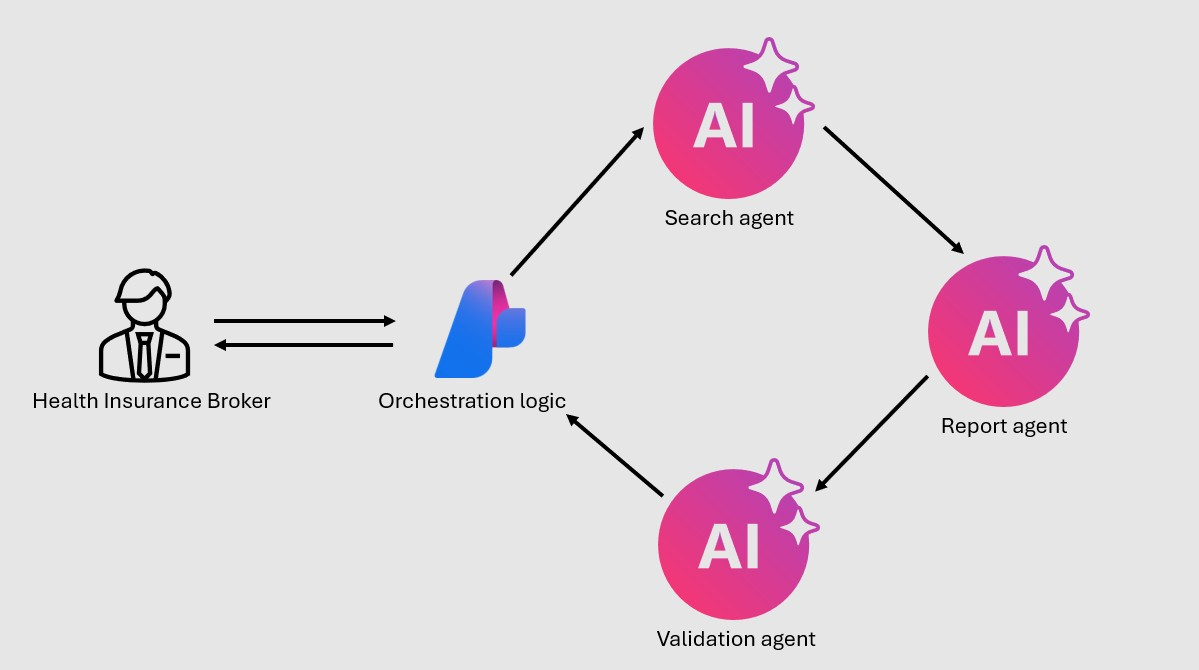


### Part 1: Create the Search, Report, and Validation Agents

#### Step 1: Load packages

In [ ]:
import os
import json
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import (
    AzureAISearchToolDefinition, AzureAISearchToolResource, AISearchIndexResource, ToolResources, AgentThreadCreationOptions
)

# Load environment variables
load_dotenv()

#### Step 2: Connect to your Azure AI Foundry Project

In [ ]:
# Connecting to our Azure AI Foundry project
project = AIProjectClient(
    endpoint=os.getenv("AIPROJECT_ENDPOINT"),
    credential=DefaultAzureCredential()
)

#### Step 3: Connect to Azure AI Search

In [ ]:
# First enter the name of your search index

index_name="<my-index-name>"
print(index_name)

In [ ]:
# Find Azure Cognitive Search connection
conn_id = None
for conn in project.connections.list():
    if getattr(conn, "type", None) == "CognitiveSearch":
        conn_id = conn.id
        break
if not conn_id:
    raise ValueError("No Azure Cognitive Search connection found in this project.")

# Define Azure AI Search tool and resources
ai_search_tool = AzureAISearchToolDefinition()
ai_search_resource = AzureAISearchToolResource(
    index_list=[
        AISearchIndexResource(
            index_connection_id=conn_id,
            index_name=index_name # Be sure to set your index name above
        )
    ]
)
tool_resources = ToolResources(azure_ai_search=ai_search_resource)

#### Step 4: Create the Search Agent
To create the Search Agent, we use the Azure AI Agent Service SDK to define a dedicated agent that specializes in searching our Azure AI Search index for health plan documents.

In [ ]:
# Search Agent
search_agent = project.agents.create_agent(
    model="gpt-4o",
    name="search-agent",
    instructions="You are a helpful agent that is an expert at searching health plan documents.",
    tools=[ai_search_tool],
    tool_resources=tool_resources
)

#### Step 5: Create the Report Agent
Similarly, to create the Report Agent, we use the Azure AI Agent Service SDK to define an agent dedicated to generating detailed reports about health plans. This agent is configured with a specialized system prompt and can be easily orchestrated alongside other agents in the workflow.

In [ ]:
# Report Agent
report_agent = project.agents.create_agent(
    model="gpt-4o",
    name="report-agent",
    instructions="You are a helpful agent that writes detailed reports about health plans."
)

#### Step 6: Create the Validation Agent
To create the Validation Agent, we again use the Azure AI Agent Service SDK to define an agent focused on validating that generated reports meet specific requirements. The Validation Agent is configured with instructions to check for required content (such as coverage exclusions) and to return a simple pass/fail result. This agent can be invoked programmatically as part of the multi-agent workflow, ensuring that all generated reports adhere to business rules before being delivered to the user.

In [ ]:
# Validation Agent
validation_agent = project.agents.create_agent(
    model="gpt-4o",
    name="validation-agent",
    instructions="You are a helpful agent that validates reports. Return 'Pass' if the report meets requirements (must include coverage exclusions), otherwise return 'Fail'. Only return 'Pass' or 'Fail'."
)

### Part 2: Orchestrate the Multi-Agent System

With our Search, Report, and Validation agents created, we can now orchestrate them together to build a collaborative multi-agent system. Using the Azure AI Agent Service SDK, we coordinate the agents programmatically in Python: the Search Agent retrieves health plan information, the Report Agent generates a detailed report, and the Validation Agent ensures the report meets required criteria (such as including coverage exclusions).

This orchestration logic is implemented directly in Python, following the latest best practices for multi-agent systems on Azure. The workflow is modular, transparent, and easy to extend—each agent performs a focused task, and the orchestration code manages the flow of information and validation between them. This approach enables robust, production-ready solutions that can be adapted to a wide range of enterprise scenarios.

Run the cell, and then type and enter the health plan you would like a report generated for (e.g., 'Northwind Standard', 'Northwind Health Plus') in the input box at the top:

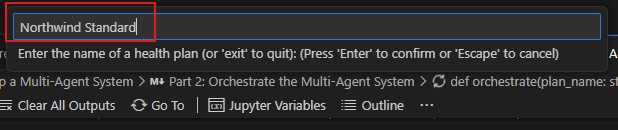


If successful, you will see the reports your agent generated saved like this:

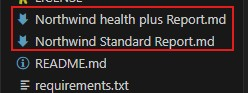

Once you are done generating report(s), enter 'exit' at the top. This will stop the process and delete your agents.

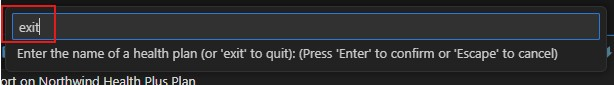

The orchestration code below...
- Defines an `orchestrate` function to coordinate the multi-agent workflow for a given health plan name:
  - The Search Agent retrieves information about the specified health plan from Azure AI Search.
  - The Report Agent generates a detailed report using the information returned by the Search Agent.
  - The Validation Agent checks that the report includes required content (coverage exclusions) and returns 'Pass' or 'Fail'.
  - If validation passes, the report is saved to a markdown file; otherwise, a message is printed indicating the report did not meet requirements.
- Defines a helper function to extract the last agent/assistant message from a list of messages.
- Provides a command-line interface to interactively enter health plan names, generate reports, and exit the system.
- Cleans up by deleting all agents when finished.

In [ ]:
def orchestrate(plan_name: str):
    # 1. Search Agent retrieves plan info
    search_thread_opts = AgentThreadCreationOptions(
        messages=[{"role": "user", "content": f"Tell me about the {plan_name} plan."}],
        tool_resources=tool_resources
    )
    search_run = project.agents.create_thread_and_process_run(
        agent_id=search_agent.id,
        thread=search_thread_opts
    )
    if search_run.status == "failed":
        raise RuntimeError(f"Search agent run failed: {search_run.last_error}")
    search_msgs = project.agents.messages.list(thread_id=search_run.thread_id)
    plan_info = extract_last_agent_message(search_msgs)

    # 2. Report Agent writes the report
    report_thread_opts = AgentThreadCreationOptions(
        messages=[{"role": "user", "content": f"Write a detailed report about the {plan_name} plan. Include coverage exclusions. Here is the relevant information: {plan_info}"}]
    )
    report_run = project.agents.create_thread_and_process_run(
        agent_id=report_agent.id,
        thread=report_thread_opts
    )
    if report_run.status == "failed":
        raise RuntimeError(f"Report agent run failed: {report_run.last_error}")
    report_msgs = project.agents.messages.list(thread_id=report_run.thread_id)
    report_content = extract_last_agent_message(report_msgs)

    # 3. Validation Agent checks the report
    validation_thread_opts = AgentThreadCreationOptions(
        messages=[{"role": "user", "content": f"Validate that the following report includes coverage exclusions. Here is the report: {report_content}"}]
    )
    validation_run = project.agents.create_thread_and_process_run(
        agent_id=validation_agent.id,
        thread=validation_thread_opts
    )
    if validation_run.status == "failed":
        raise RuntimeError(f"Validation agent run failed: {validation_run.last_error}")
    validation_msgs = project.agents.messages.list(thread_id=validation_run.thread_id)
    validation_result = extract_last_agent_message(validation_msgs)

    # 4. Output result
    if validation_result.strip().lower() == "pass":
        filename = f"{plan_name} Report.md"
        with open(filename, "w", encoding="utf-8") as f:
            f.write(report_content)
        print(f"Report generated and saved to {filename}.")
        return {"report_was_generated": True, "content": report_content}
    else:
        print("Report did not meet validation requirements.")
        return {"report_was_generated": False, "content": "The report could not be generated as it did not meet the required validation standards."}

def extract_last_agent_message(messages):
    # Helper to extract the last agent/assistant message's text
    last_msg = None
    for msg in reversed(list(messages)):
        role = getattr(msg, "role", None)
        if role and ("agent" in role.lower() or "assistant" in role.lower()):
            last_msg = msg
            break
    if last_msg and getattr(last_msg, "content", None) and isinstance(last_msg.content, list):
        for part in last_msg.content:
            if part.get("type") == "text" and "text" in part and "value" in part["text"]:
                return part["text"]["value"]
    return ""

if __name__ == "__main__":
    print("Welcome to the Health Plan Multi-Agent System!")
    while True:
        plan_name = input("Enter the name of a health plan (or 'exit' to quit): ").strip()
        if not plan_name or plan_name.lower() == "exit":
            break
        result = orchestrate(plan_name)
        print(json.dumps(result, indent=2))

    # Cleanup: delete agents (optional, for resource management)
    project.agents.delete_agent(search_agent.id)
    project.agents.delete_agent(report_agent.id)
    project.agents.delete_agent(validation_agent.id)
    print("Agents deleted. Goodbye!")